## Load data

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Load your sequential data of electricity demand
# Assuming your data is in a CSV file, with 'demand' column representing the electricity demand
data = pd.read_csv("./data/TCQ_DemandSum_DST.csv")

data['Target'] = data['Sum of DST']

## Autocorrelation

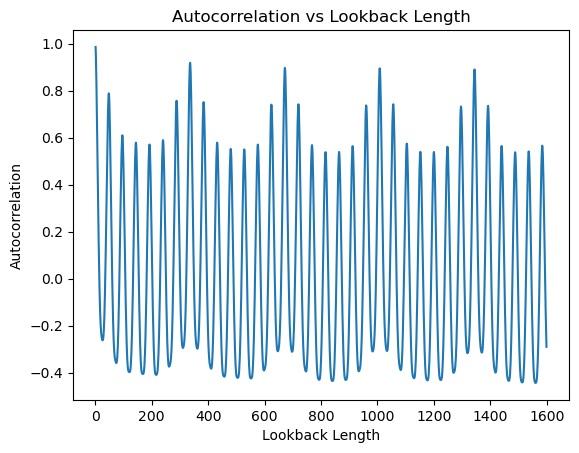

Best Lookback Length: 336


In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Calculate autocorrelation for different lookback lengths
lookback_lengths = range(1, 1600)
autocorrelation_values = []
for lookback in lookback_lengths:
  autocorrelation = data['Target'].autocorr(lag=lookback)
  autocorrelation_values.append(autocorrelation)

# Plot autocorrelation values
plt.plot(lookback_lengths, autocorrelation_values)
plt.xlabel('Lookback Length')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation vs Lookback Length')
plt.show()

# Sort the autocorrelation values in descending order
sorted_autocorrelation_values = sorted(autocorrelation_values, reverse=True)

best_lookback_length = max([lookback for lookback in lookback_lengths if lookback > 2], key=lambda x: autocorrelation_values[x-1])
print('Best Lookback Length:', best_lookback_length)


## Data transformation

In [ ]:
# Subtract the average from the data
target_avg = data['Target'].mean()
target_avg = 0 # Hardcoded average demand, 0 means no subtraction
print("Average demand: ", target_avg)
data['Target'] = data['Target'] - target_avg

# Normalize the data
# scaler = MinMaxScaler(feature_range=(0, 1))
scaler = StandardScaler()
data['Target'] = scaler.fit_transform(data['Target'].values.reshape(-1,1))


## Prepare Training Data

In [ ]:

# Function to create dataset with sequences of 48 demand values
def create_dataset(dataset, weeks=0, days=0, periods=48):
    look_back=periods + (days * 48) + (weeks * 7 * 48)
    X, Y = [], []
    for i in range(len(dataset)-look_back):
        X.append(dataset[i:(i+look_back)])
        Y.append(dataset[i + look_back])
    return np.array(X), np.array(Y)

# Split data into training and testing sets
train_size = int(len(data) * 0.7)
validate_size = int(len(data) * 0.1)
test_size = len(data) - train_size - validate_size
train, validate, test = data.iloc[0:train_size], \
                        data.iloc[train_size:train_size+validate_size], \
                        data.iloc[train_size+validate_size:len(data)]

# Create datasets for training and testing
weeks = 1
days = 0
periods = 0
train_X, train_Y = create_dataset(train['Target'].values, weeks=weeks, days=days, periods=periods)
validate_X, validate_Y = create_dataset(validate['Target'].values, weeks=weeks, days=days, periods=periods)
test_X, test_Y = create_dataset(test['Target'].values, weeks=weeks, days=days, periods=periods)


In [3]:
print(f"Next, reshape to {(train_X.shape[0], train_X.shape[1], 1)}")

Next, reshape to (8299, 336, 1)


In [4]:

# Reshape input to be [samples, time steps, features]
train_X = np.reshape(train_X, (train_X.shape[0], train_X.shape[1], 1))
test_X = np.reshape(test_X, (test_X.shape[0], test_X.shape[1], 1))


## LSTM

In [5]:
import tensorflow as tf

tf.keras.utils.disable_interactive_logging()
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


2024-03-20 14:25:38.146375: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-20 14:25:38.182055: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-20 14:25:38.182306: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [12]:
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.model_selection import GridSearchCV

def build_model(optimizer='adam'):
    model = Sequential()
    model.add(LSTM(64, input_shape=(train_X.shape[1], 1)))
    model.add(Dense(4, activation='sigmoid'))
    model.add(Dense(1))

    model.compile(loss="mse", optimizer=optimizer, verbose=0)
    return model

In [10]:
# Define the hyperparameters grid
batch_size = [32, 64, 128]
epochs = [100, 150, 200]
optimizer = ['adam', 'rmsprop']
param_grid = dict(
    batch_size=batch_size, 
    epochs=epochs, 
    optimizer=optimizer
    )
param_grid


{'batch_size': [32, 64, 128],
 'epochs': [100, 150, 200],
 'optimizer': ['adam', 'rmsprop']}

In [13]:
from scikeras.wrappers import KerasRegressor
model = KerasRegressor(build_fn=build_model, verbose=1)

# Create GridSearchCV instance
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3)

# Fit the grid search to the data
grid_search.fit(train_X, train_Y)

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best parameters:", best_params)
print("Best score:", best_score)


/home/meta/anaconda3/envs/sp-tf/lib/python3.11/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
2024-03-20 14:27:15.466842: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-20 14:27:15.467118: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-20 14:27:15.467285: I external/local_xla/xla/stream_executor/cu

Epoch 1/100


2024-03-20 14:27:17.106943: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-03-20 14:27:17.481839: I external/local_xla/xla/service/service.cc:168] XLA service 0x7b3810140650 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-03-20 14:27:17.481879: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1650, Compute Capability 7.5
2024-03-20 14:27:17.487303: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1710916037.564162  434067 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


173/173 [==============================] - 4s 10ms/step - loss: 0.3429
Epoch 2/100
173/173 [==============================] - 2s 9ms/step - loss: 0.0814
Epoch 3/100
173/173 [==============================] - 2s 9ms/step - loss: 0.0463
Epoch 4/100
173/173 [==============================] - 2s 9ms/step - loss: 0.0319
Epoch 5/100
173/173 [==============================] - 2s 9ms/step - loss: 0.0238
Epoch 6/100
173/173 [==============================] - 2s 9ms/step - loss: 0.0187
Epoch 7/100
173/173 [==============================] - 2s 9ms/step - loss: 0.0154
Epoch 8/100
173/173 [==============================] - 2s 9ms/step - loss: 0.0132
Epoch 9/100
173/173 [==============================] - 2s 9ms/step - loss: 0.0118
Epoch 10/100
173/173 [==============================] - 2s 9ms/step - loss: 0.0103
Epoch 11/100
173/173 [==============================] - 2s 9ms/step - loss: 0.0092
Epoch 12/100
173/173 [==============================] - 2s 9ms/step - loss: 0.0081
Epoch 13/100
173/173 [==

/home/meta/anaconda3/envs/sp-tf/lib/python3.11/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/100
173/173 [==============================] - 3s 10ms/step - loss: 0.5636
Epoch 2/100
173/173 [==============================] - 2s 10ms/step - loss: 0.1847
Epoch 3/100
173/173 [==============================] - 2s 10ms/step - loss: 0.1005
Epoch 4/100
173/173 [==============================] - 2s 10ms/step - loss: 0.0611
Epoch 5/100
173/173 [==============================] - 2s 10ms/step - loss: 0.0413
Epoch 6/100
173/173 [==============================] - 2s 10ms/step - loss: 0.0307
Epoch 7/100
173/173 [==============================] - 2s 10ms/step - loss: 0.0248
Epoch 8/100
173/173 [==============================] - 2s 10ms/step - loss: 0.0209
Epoch 9/100
173/173 [==============================] - 2s 10ms/step - loss: 0.0178
Epoch 10/100
173/173 [==============================] - 2s 10ms/step - loss: 0.0157
Epoch 11/100
173/173 [==============================] - 2s 10ms/step - loss: 0.0136
Epoch 12/100
173/173 [==============================] - 2s 10ms/step - loss: 0.0120
E

/home/meta/anaconda3/envs/sp-tf/lib/python3.11/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/100
173/173 [==============================] - 4s 11ms/step - loss: 0.2860
Epoch 2/100
173/173 [==============================] - 2s 11ms/step - loss: 0.0611
Epoch 3/100
173/173 [==============================] - 2s 11ms/step - loss: 0.0365
Epoch 4/100
173/173 [==============================] - 2s 11ms/step - loss: 0.0267
Epoch 5/100
173/173 [==============================] - 2s 11ms/step - loss: 0.0204
Epoch 6/100
173/173 [==============================] - 2s 10ms/step - loss: 0.0165
Epoch 7/100
173/173 [==============================] - 2s 11ms/step - loss: 0.0146
Epoch 8/100
173/173 [==============================] - 2s 11ms/step - loss: 0.0125
Epoch 9/100
173/173 [==============================] - 2s 11ms/step - loss: 0.0107
Epoch 10/100
173/173 [==============================] - 2s 11ms/step - loss: 0.0098
Epoch 11/100
173/173 [==============================] - 2s 11ms/step - loss: 0.0090
Epoch 12/100
173/173 [==============================] - 2s 10ms/step - loss: 0.0079
E

/home/meta/anaconda3/envs/sp-tf/lib/python3.11/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/100
173/173 [==============================] - 4s 11ms/step - loss: 0.2387
Epoch 2/100
173/173 [==============================] - 2s 11ms/step - loss: 0.0431
Epoch 3/100
173/173 [==============================] - 2s 11ms/step - loss: 0.0268
Epoch 4/100
173/173 [==============================] - 2s 11ms/step - loss: 0.0215
Epoch 5/100
173/173 [==============================] - 2s 11ms/step - loss: 0.0179
Epoch 6/100
173/173 [==============================] - 2s 11ms/step - loss: 0.0154
Epoch 7/100
173/173 [==============================] - 2s 11ms/step - loss: 0.0143
Epoch 8/100
173/173 [==============================] - 2s 11ms/step - loss: 0.0128
Epoch 9/100
173/173 [==============================] - 2s 11ms/step - loss: 0.0113
Epoch 10/100
173/173 [==============================] - 2s 11ms/step - loss: 0.0104
Epoch 11/100
173/173 [==============================] - 2s 11ms/step - loss: 0.0095
Epoch 12/100
173/173 [==============================] - 2s 11ms/step - loss: 0.0085
E

/home/meta/anaconda3/envs/sp-tf/lib/python3.11/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/100
173/173 [==============================] - 4s 11ms/step - loss: 0.2662
Epoch 2/100
173/173 [==============================] - 2s 12ms/step - loss: 0.0541
Epoch 3/100
173/173 [==============================] - 2s 11ms/step - loss: 0.0349
Epoch 4/100
173/173 [==============================] - 2s 12ms/step - loss: 0.0257
Epoch 5/100
173/173 [==============================] - 2s 12ms/step - loss: 0.0201
Epoch 6/100
173/173 [==============================] - 2s 12ms/step - loss: 0.0166
Epoch 7/100
173/173 [==============================] - 2s 12ms/step - loss: 0.0140
Epoch 8/100
173/173 [==============================] - 2s 12ms/step - loss: 0.0119
Epoch 9/100
173/173 [==============================] - 2s 11ms/step - loss: 0.0108
Epoch 10/100
173/173 [==============================] - 2s 11ms/step - loss: 0.0098
Epoch 11/100
173/173 [==============================] - 2s 12ms/step - loss: 0.0089
Epoch 12/100
173/173 [==============================] - 2s 12ms/step - loss: 0.0079
E

/home/meta/anaconda3/envs/sp-tf/lib/python3.11/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/100
173/173 [==============================] - 4s 11ms/step - loss: 0.5524
Epoch 2/100
173/173 [==============================] - 2s 12ms/step - loss: 0.1874
Epoch 3/100
173/173 [==============================] - 2s 12ms/step - loss: 0.0938
Epoch 4/100
173/173 [==============================] - 2s 12ms/step - loss: 0.0544
Epoch 5/100
173/173 [==============================] - 2s 12ms/step - loss: 0.0364
Epoch 6/100
173/173 [==============================] - 2s 12ms/step - loss: 0.0276
Epoch 7/100
173/173 [==============================] - 2s 12ms/step - loss: 0.0217
Epoch 8/100
173/173 [==============================] - 2s 12ms/step - loss: 0.0193
Epoch 9/100
173/173 [==============================] - 2s 12ms/step - loss: 0.0161
Epoch 10/100
173/173 [==============================] - 2s 12ms/step - loss: 0.0142
Epoch 11/100
173/173 [==============================] - 2s 13ms/step - loss: 0.0124
Epoch 12/100
173/173 [==============================] - 2s 13ms/step - loss: 0.0112
E

/home/meta/anaconda3/envs/sp-tf/lib/python3.11/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/150
173/173 [==============================] - 4s 11ms/step - loss: 0.5367
Epoch 2/150
173/173 [==============================] - 2s 11ms/step - loss: 0.1612
Epoch 3/150
173/173 [==============================] - 2s 11ms/step - loss: 0.0790
Epoch 4/150
173/173 [==============================] - 2s 11ms/step - loss: 0.0481
Epoch 5/150
173/173 [==============================] - 2s 12ms/step - loss: 0.0341
Epoch 6/150
173/173 [==============================] - 2s 12ms/step - loss: 0.0256
Epoch 7/150
173/173 [==============================] - 2s 12ms/step - loss: 0.0206
Epoch 8/150
173/173 [==============================] - 2s 12ms/step - loss: 0.0174
Epoch 9/150
173/173 [==============================] - 2s 12ms/step - loss: 0.0147
Epoch 10/150
173/173 [==============================] - 2s 12ms/step - loss: 0.0137
Epoch 11/150
173/173 [==============================] - 2s 12ms/step - loss: 0.0113
Epoch 12/150
173/173 [==============================] - 2s 12ms/step - loss: 0.0102
E

/home/meta/anaconda3/envs/sp-tf/lib/python3.11/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/150
173/173 [==============================] - 4s 11ms/step - loss: 0.3004
Epoch 2/150
173/173 [==============================] - 2s 12ms/step - loss: 0.0627
Epoch 3/150
173/173 [==============================] - 2s 11ms/step - loss: 0.0364
Epoch 4/150
173/173 [==============================] - 2s 12ms/step - loss: 0.0268
Epoch 5/150
173/173 [==============================] - 2s 12ms/step - loss: 0.0215
Epoch 6/150
173/173 [==============================] - 2s 12ms/step - loss: 0.0170
Epoch 7/150
173/173 [==============================] - 2s 12ms/step - loss: 0.0150
Epoch 8/150
173/173 [==============================] - 2s 12ms/step - loss: 0.0130
Epoch 9/150
173/173 [==============================] - 2s 12ms/step - loss: 0.0120
Epoch 10/150
173/173 [==============================] - 2s 12ms/step - loss: 0.0102
Epoch 11/150
173/173 [==============================] - 2s 12ms/step - loss: 0.0091
Epoch 12/150
173/173 [==============================] - 2s 12ms/step - loss: 0.0085
E

/home/meta/anaconda3/envs/sp-tf/lib/python3.11/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/150
173/173 [==============================] - 4s 12ms/step - loss: 0.3538
Epoch 2/150
173/173 [==============================] - 2s 12ms/step - loss: 0.1056
Epoch 3/150
173/173 [==============================] - 2s 12ms/step - loss: 0.0584
Epoch 4/150
173/173 [==============================] - 2s 12ms/step - loss: 0.0382
Epoch 5/150
173/173 [==============================] - 2s 12ms/step - loss: 0.0281
Epoch 6/150
173/173 [==============================] - 2s 12ms/step - loss: 0.0211
Epoch 7/150
173/173 [==============================] - 2s 12ms/step - loss: 0.0174
Epoch 8/150
173/173 [==============================] - 2s 12ms/step - loss: 0.0149
Epoch 9/150
173/173 [==============================] - 2s 12ms/step - loss: 0.0127
Epoch 10/150
173/173 [==============================] - 2s 12ms/step - loss: 0.0109
Epoch 11/150
173/173 [==============================] - 2s 12ms/step - loss: 0.0095
Epoch 12/150
173/173 [==============================] - 2s 12ms/step - loss: 0.0088
E

/home/meta/anaconda3/envs/sp-tf/lib/python3.11/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/150
173/173 [==============================] - 4s 11ms/step - loss: 0.3992
Epoch 2/150
173/173 [==============================] - 2s 12ms/step - loss: 0.1048
Epoch 3/150
173/173 [==============================] - 2s 12ms/step - loss: 0.0601
Epoch 4/150
173/173 [==============================] - 2s 12ms/step - loss: 0.0406
Epoch 5/150
173/173 [==============================] - 2s 12ms/step - loss: 0.0296
Epoch 6/150
173/173 [==============================] - 2s 12ms/step - loss: 0.0236
Epoch 7/150
173/173 [==============================] - 2s 12ms/step - loss: 0.0200
Epoch 8/150
173/173 [==============================] - 2s 12ms/step - loss: 0.0178
Epoch 9/150
173/173 [==============================] - 2s 12ms/step - loss: 0.0156
Epoch 10/150
173/173 [==============================] - 2s 12ms/step - loss: 0.0136
Epoch 11/150
173/173 [==============================] - 2s 12ms/step - loss: 0.0125
Epoch 12/150
173/173 [==============================] - 2s 12ms/step - loss: 0.0112
E

/home/meta/anaconda3/envs/sp-tf/lib/python3.11/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/150
173/173 [==============================] - 4s 12ms/step - loss: 0.3403
Epoch 2/150
173/173 [==============================] - 2s 12ms/step - loss: 0.0784
Epoch 3/150
173/173 [==============================] - 2s 12ms/step - loss: 0.0436
Epoch 4/150
173/173 [==============================] - 2s 12ms/step - loss: 0.0305
Epoch 5/150
173/173 [==============================] - 2s 12ms/step - loss: 0.0252
Epoch 6/150
173/173 [==============================] - 2s 12ms/step - loss: 0.0203
Epoch 7/150
173/173 [==============================] - 2s 12ms/step - loss: 0.0169
Epoch 8/150
173/173 [==============================] - 2s 12ms/step - loss: 0.0148
Epoch 9/150
173/173 [==============================] - 2s 12ms/step - loss: 0.0135
Epoch 10/150
173/173 [==============================] - 2s 12ms/step - loss: 0.0119
Epoch 11/150
173/173 [==============================] - 2s 12ms/step - loss: 0.0108
Epoch 12/150
173/173 [==============================] - 2s 12ms/step - loss: 0.0098
E

/home/meta/anaconda3/envs/sp-tf/lib/python3.11/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/150
173/173 [==============================] - 4s 11ms/step - loss: 0.3193
Epoch 2/150
173/173 [==============================] - 2s 12ms/step - loss: 0.0715
Epoch 3/150
173/173 [==============================] - 2s 12ms/step - loss: 0.0420
Epoch 4/150
173/173 [==============================] - 2s 12ms/step - loss: 0.0283
Epoch 5/150
173/173 [==============================] - 2s 12ms/step - loss: 0.0209
Epoch 6/150
173/173 [==============================] - 2s 12ms/step - loss: 0.0171
Epoch 7/150
173/173 [==============================] - 2s 12ms/step - loss: 0.0148
Epoch 8/150
173/173 [==============================] - 2s 12ms/step - loss: 0.0127
Epoch 9/150
173/173 [==============================] - 2s 12ms/step - loss: 0.0113
Epoch 10/150
173/173 [==============================] - 2s 12ms/step - loss: 0.0100
Epoch 11/150
173/173 [==============================] - 2s 12ms/step - loss: 0.0090
Epoch 12/150
173/173 [==============================] - 2s 12ms/step - loss: 0.0083
E

/home/meta/anaconda3/envs/sp-tf/lib/python3.11/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/200
173/173 [==============================] - 4s 12ms/step - loss: 0.4004
Epoch 2/200
173/173 [==============================] - 2s 12ms/step - loss: 0.1044
Epoch 3/200
173/173 [==============================] - 2s 12ms/step - loss: 0.0557
Epoch 4/200
173/173 [==============================] - 2s 12ms/step - loss: 0.0365
Epoch 5/200
173/173 [==============================] - 2s 12ms/step - loss: 0.0273
Epoch 6/200
173/173 [==============================] - 2s 12ms/step - loss: 0.0214
Epoch 7/200
173/173 [==============================] - 2s 12ms/step - loss: 0.0182
Epoch 8/200
173/173 [==============================] - 2s 12ms/step - loss: 0.0152
Epoch 9/200
173/173 [==============================] - 2s 12ms/step - loss: 0.0131
Epoch 10/200
173/173 [==============================] - 2s 12ms/step - loss: 0.0120
Epoch 11/200
173/173 [==============================] - 2s 12ms/step - loss: 0.0104
Epoch 12/200
173/173 [==============================] - 2s 12ms/step - loss: 0.0091
E

/home/meta/anaconda3/envs/sp-tf/lib/python3.11/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/200
173/173 [==============================] - 4s 12ms/step - loss: 0.2798
Epoch 2/200
173/173 [==============================] - 2s 12ms/step - loss: 0.0616
Epoch 3/200
173/173 [==============================] - 2s 12ms/step - loss: 0.0383
Epoch 4/200
173/173 [==============================] - 2s 12ms/step - loss: 0.0279
Epoch 5/200
173/173 [==============================] - 2s 12ms/step - loss: 0.0221
Epoch 6/200
173/173 [==============================] - 2s 12ms/step - loss: 0.0181
Epoch 7/200
173/173 [==============================] - 2s 12ms/step - loss: 0.0153
Epoch 8/200
173/173 [==============================] - 2s 12ms/step - loss: 0.0134
Epoch 9/200
173/173 [==============================] - 2s 12ms/step - loss: 0.0120
Epoch 10/200
173/173 [==============================] - 2s 12ms/step - loss: 0.0107
Epoch 11/200
173/173 [==============================] - 2s 12ms/step - loss: 0.0097
Epoch 12/200
173/173 [==============================] - 2s 12ms/step - loss: 0.0088
E

/home/meta/anaconda3/envs/sp-tf/lib/python3.11/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/200
173/173 [==============================] - 4s 12ms/step - loss: 0.3836
Epoch 2/200
173/173 [==============================] - 2s 12ms/step - loss: 0.0981
Epoch 3/200
173/173 [==============================] - 2s 12ms/step - loss: 0.0511
Epoch 4/200
173/173 [==============================] - 2s 12ms/step - loss: 0.0332
Epoch 5/200
173/173 [==============================] - 2s 12ms/step - loss: 0.0249
Epoch 6/200
173/173 [==============================] - 2s 12ms/step - loss: 0.0192
Epoch 7/200
173/173 [==============================] - 2s 12ms/step - loss: 0.0162
Epoch 8/200
173/173 [==============================] - 2s 12ms/step - loss: 0.0142
Epoch 9/200
173/173 [==============================] - 2s 12ms/step - loss: 0.0122
Epoch 10/200
173/173 [==============================] - 2s 12ms/step - loss: 0.0108
Epoch 11/200
173/173 [==============================] - 2s 12ms/step - loss: 0.0097
Epoch 12/200
173/173 [==============================] - 2s 12ms/step - loss: 0.0087
E

/home/meta/anaconda3/envs/sp-tf/lib/python3.11/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/200
173/173 [==============================] - 4s 12ms/step - loss: 0.5705
Epoch 2/200
173/173 [==============================] - 2s 12ms/step - loss: 0.1367
Epoch 3/200
173/173 [==============================] - 2s 12ms/step - loss: 0.0656
Epoch 4/200
173/173 [==============================] - 2s 12ms/step - loss: 0.0400
Epoch 5/200
173/173 [==============================] - 2s 12ms/step - loss: 0.0290
Epoch 6/200
173/173 [==============================] - 2s 12ms/step - loss: 0.0234
Epoch 7/200
173/173 [==============================] - 2s 12ms/step - loss: 0.0200
Epoch 8/200
173/173 [==============================] - 2s 12ms/step - loss: 0.0175
Epoch 9/200
173/173 [==============================] - 2s 12ms/step - loss: 0.0155
Epoch 10/200
173/173 [==============================] - 2s 12ms/step - loss: 0.0136
Epoch 11/200
173/173 [==============================] - 2s 12ms/step - loss: 0.0124
Epoch 12/200
173/173 [==============================] - 2s 12ms/step - loss: 0.0115
E

/home/meta/anaconda3/envs/sp-tf/lib/python3.11/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/200
173/173 [==============================] - 4s 12ms/step - loss: 0.3727
Epoch 2/200
173/173 [==============================] - 2s 12ms/step - loss: 0.0855
Epoch 3/200
173/173 [==============================] - 2s 12ms/step - loss: 0.0485
Epoch 4/200
173/173 [==============================] - 2s 12ms/step - loss: 0.0321
Epoch 5/200
173/173 [==============================] - 2s 12ms/step - loss: 0.0240
Epoch 6/200
173/173 [==============================] - 2s 12ms/step - loss: 0.0194
Epoch 7/200
173/173 [==============================] - 2s 12ms/step - loss: 0.0159
Epoch 8/200
173/173 [==============================] - 2s 12ms/step - loss: 0.0139
Epoch 9/200
173/173 [==============================] - 2s 12ms/step - loss: 0.0119
Epoch 10/200
173/173 [==============================] - 2s 12ms/step - loss: 0.0109
Epoch 11/200
173/173 [==============================] - 2s 12ms/step - loss: 0.0096
Epoch 12/200
173/173 [==============================] - 2s 12ms/step - loss: 0.0084
E

In [ ]:
model.history.history.keys()

In [ ]:
loss_history = [model.history.history['loss'], model.history.history['val_loss']]
loss_history = pd.DataFrame(loss_history).T

In [ ]:
loss_history.columns = ['loss', 'val_loss']
print(loss_history.iloc[-1])

loss_history.plot()

## Predict & Evaluate

In [ ]:
from sklearn.metrics import mean_squared_error

# Make predictions
train_predict = model.predict(train_X)
test_predict = model.predict(test_X)

# Invert predictions to original scale
i_train_predict = scaler.inverse_transform(train_predict) + target_avg
i_train_Y = scaler.inverse_transform([train_Y]) + target_avg
i_test_predict = scaler.inverse_transform(test_predict) + target_avg
i_test_Y = scaler.inverse_transform([test_Y]) + target_avg


# Calculate root mean squared error
train_score = np.sqrt(mean_squared_error(i_train_Y[0], i_train_predict[:,0]))
test_score = np.sqrt(mean_squared_error(i_test_Y[0], i_test_predict[:,0]))
print('Train RMSE:', train_score)
print('Test RMSE:', test_score)

In [ ]:
import matplotlib.pyplot as plt

# Plot train data
plt.figure(figsize=(40, 6))
plt.plot(i_train_Y[0], label='Actual')
plt.plot(i_train_predict[:, 0], label='Predicted')
plt.title('Train Data: Actual vs Predicted')
plt.xlabel('Time')
plt.ylabel('Demand')
plt.legend()
plt.show()

# Plot test data
plt.figure(figsize=(40, 6))
plt.plot(i_test_Y[0], label='Actual')
plt.plot(i_test_predict[:, 0], label='Predicted')
plt.title('Test Data: Actual vs Predicted')
plt.xlabel('Time')
plt.ylabel('Demand')
plt.legend()
plt.show()


In [ ]:
# for i in range(50):
#     print(f"test_Y[{i:03d}]: {i_test_Y[0][i]:.12f}, test_predict[{i:03d}]: {i_test_predict[i][0]:.12f}, diff: {abs(i_test_predict[i][0] - i_test_Y[0][i]):.12f}")